### Project 5: Worm Algorithm for the 6-Vertex Model (Monte Carlo)

Date: <span style = "color: wheat"> 05.07.2025 </span> | Author of the code: <span style = "color: wheat"> Matthias Pawlik </span>

Implement the worm algorithm discussed in the lecture for the 6-vertex model (https://en.wikipedia.org/wiki/Ice-type_model) at infinite temperature, where all allowed configurations are equally likely. Calculate the correlation function $\langle s_0 s_r \rangle \propto 1/r^a$ and extract the decay exponent $a$.

In [31]:
# Import of libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as optimize

In [32]:
# Definition of the ice-type model
class six_vertex_model(object):
    """Ice-type (6-vertex) model class with periodic boundary conditions.
    
    Attributes
    ----------
    Lx : int
        Lattice X size.
    Ly : int
        Lattice Y size.
    N : int
        Number of vertices.
    lattice : list
        Horizontal (hor) & vertical (ver) sublattices.
        Shape: ((Ly, Lx), (Lx, Ly))

    Methods
    -------
    - plot()
    - get_vertex_in_out(x, y)
    - get_vertex_charge(x, y)
    - get_next_vertex(x, y, flip)
    - flip_arrow(x, y, flip)
    - flip_next_arrow(x, y, flip)
    - check_valid_config()
    - propagate_defect()
    - thermalize(N)
    - fancy_plot()
    - measure_correlations()
    
    """

    def __init__(self, Lx, Ly, hor=[], ver=[]):
        """ hor, ver: initial lattice configuration.
        """
        self.Lx = Lx
        self.Ly = Ly
        self.N = Lx * Ly

        assert Lx == Ly # Square lattice for fast numpy manipulations

        # Assume periodic boundary conditions (PBC)
        # hor[_][0] = hor[_][Lx+1] and ver[_][0] = ver[_][Ly+1]
        if hor == [] or ver == []:
            hor = np.ones((Ly, Lx), dtype = np.int8)
            ver = np.ones((Lx, Ly), dtype = np.int8)
            # Initial state: alternate arrows from line to line
            hor[1::2] *= -1
            ver[1::2] *= -1
            self.lattice = np.array([hor, ver]) # shape: ((Ly, Lx), (Lx, Ly))
        else:
            assert hor.shape == (Ly, Lx) and ver.shape == (Lx, Ly)
            self.lattice = np.array([hor, ver]) # shape: ((Ly, Lx), (Lx, Ly))
            self.check_valid_config()

    def plot(self):
        """ Plot hor & ver sublattices ('ver' transposed for graphical purposes).
        """
        print('Horizontal arrows:')
        print(self.lattice[0], '\n')
        print('Vertical arrows:')
        print(self.lattice[1].transpose(), '\n')


    def get_vertex_in_out(self, x, y):
        """ Return arrow values: np.array([arrow_left, arrow_right, arrow_up, arrow_down]) relative to vertex (x, y).
        Ingoing  : +1
        Outgoing : -1
        """
        arrow_left  = self.lattice[0, x, y]
        arrow_right = self.lattice[0, x, (y+1) % self.Lx] * -1
        arrow_up    = self.lattice[1, y, x] * -1
        arrow_down  = self.lattice[1, y, (x+1) % self.Ly]
        return np.array([arrow_left, arrow_right, arrow_up, arrow_down])


    def get_vertex_charge(self, x, y):
        """ Return magnetic charge of vertex (x, y).
        """
        return np.sum(self.get_vertex_in_out(x, y)) / 2
    

    def get_next_vertex(self, x, y, flip):
        """ Return coordinates of neighbor vertex in the flip direction and flip relative to that vertex.
        x, y : Coordinates of the first vertex
        flip : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        if flip == 0:   # left
            return x, (y-1) % self.Lx, 1
        elif flip == 1: # right
            return x, (y+1) % self.Lx, 0
        elif flip == 2: # up
            return (x-1) % self.Ly, y, 3
        else:           # down
            return (x+1) % self.Ly, y, 2
        
    
    def flip_arrow(self, x, y, flip):
        """ Create 2 defects by flipping 1 arrow.
        x, y : Vertex coordinates
        flip : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        if flip == 0:   # left
            self.lattice[0, x, y] *= -1
        elif flip == 1: # right
            self.lattice[0, x, (y+1) % self.Lx] *= -1
        elif flip == 2: # up
            self.lattice[1, y, x] *= -1
        else:           # down
            self.lattice[1, y, (x+1) % self.Ly] *= -1


    def flip_next(self, x, y, flipped):
        """ Propagate defect by flipping randomly one of the other arrows of the vertex, subject to the ice rule (2-in, 2-out).
        Return next vertex coordinates & new flip relative to that vertex.
        x, y    : Vertex coordinates
        flipped : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        in_or_out = self.get_vertex_in_out(x, y)
        flipped_dir = in_or_out[flipped] # in: 1, out: -1
        
        in_or_out[flipped] = 0 # Remove old direction from possibilities
        possible = np.arange(4)[in_or_out == flipped_dir] # 2 new flip directions
  
        flip_new = -1
        prob = np.random.random() # 50/50 chance
        if prob < 0.5:
            flip_new = possible[0]
        else:
            flip_new = possible[1]

        self.flip_arrow(x, y, flip_new)
        return self.get_next_vertex(x, y, flip_new)
    

    def propagate_defect(self):
        """ Flip 1 arrow, create 2 defective vertices & propagate one randomly until they meet & annihilate each other.
        """
        x = np.random.randint(self.Lx) # vertex x coordinate
        y = np.random.randint(self.Ly) # vertex y coordinate
        flip = np.random.randint(4) # left: 0, right: 1, up: 2, down: 3
        
        self.flip_arrow(x, y, flip)
        xf, yf, _ = self.get_next_vertex(x, y, flip) # end vertex coordinates (x_f, y_f)
        
        propagate = True
        while propagate:
            x, y, flip = self.flip_next(x, y, flip)
            if (x, y) == (xf, yf): # defects meet & annihilate
                propagate = False


    def thermalize(self, N=1000):
        """ Thermalize system by running 'propagate_defect' N times.
        """
        for _ in range(N):
            self.propagate_defect()

        
    def check_valid_config(self):
        """ Check if the system respects the ice rule (2-in, 2-out).
        Return number of defects (charged vertices).
        """
        charged = 0
        for x in range(self.Ly):
            for y in range(self.Lx):
                if self.get_vertex_charge(x, y) != 0:
                    charged += 1

        if charged == 0:
            print('6-vertex configuration is valid. No finite-charge vertices.')
        else:
            print('6-vertex configuration is not valid!', charged, 'finite-charge vertices.')

    
    def fancy_plot(self, figsize=(8,8)):
        """ Plot the lattice with arrows for each arrow at every vertex.
        Ingoing  : blue arrow
        Outgoing : purple arrow
        """

        fig, ax = plt.subplots(figsize = figsize)
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, self.Lx-0.5)
        ax.set_ylim(-0.5, self.Ly-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor('lightgray')

        # Arrow properties
        arrowprops = dict(width=0.03, head_width=0.13, head_length=0.13, length_includes_head=True)
        color_in = 'steelblue'
        color_out = 'purple'
        r = 0.45

        for x in range(self.Ly):
            for y in range(self.Lx):
                # Draw vertex tile
                rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='none')
                ax.add_patch(rect)

                # Get arrow directions for this vertex
                arrow_left, arrow_right, arrow_up, arrow_down = self.get_vertex_in_out(x, y)

                cx, cy = y, x # Center of the tile

                # Left arrow
                if arrow_left == 1: # in
                    ax.arrow(cx - r, cy, r, 0, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, -r, 0, color=color_out, **arrowprops)

                # Right arrow
                if arrow_right == 1: # in
                    ax.arrow(cx + r, cy, -r, 0, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, r, 0, color=color_out, **arrowprops)

                # Up arrow
                if arrow_up == 1: # in
                    ax.arrow(cx, cy - r, 0, r, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, 0, -r, color=color_out, **arrowprops)

                # Down arrow
                if arrow_down == 1: # in
                    ax.arrow(cx, cy + r, 0, -r, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, 0, r, color=color_out, **arrowprops)

        plt.title('Arrow Configuration 6-Vertex Model')
        plt.show()

    
    def measure_correlations(self, corr='all'):

        """ Measure arrow correlations with distance on square lattice.
        Errors are decreased using translational & rotational invariance.
                
        Return (corr == 'all'):
            1) corr_hor_hor : horizontal correlations of horizontal arrows.
            2) corr_ver_ver : vertical correlations of vertical arrows.
            3) corr_ver_hor : vertical correlations of horizontal arrows.
            4) corr_hor_ver : horizontal correlations of vertical arrows.
            
        Due to rotational invariance:
        - 1) & 2) should be the same.
        - 3) & 4) should be the same.
        
        Return (corr == 'rot_invar'):
            - corr_along : correlations along arrow direction.
            - corr_perp  : correlations perpendicular to arrow direction.
        """

        assert self.Lx == self.Ly # Square lattice
        L = self.Lx

        corr_hor_hor = np.empty((L, L - 1))
        corr_ver_ver = np.empty((L, L - 1))
        corr_ver_hor = np.empty((L, L - 1))
        corr_hor_ver = np.empty((L, L - 1))

        # Horizontal & vertical correlations
        for i in range(L):
            corr_hor_hor[i] = np.sum(self.lattice[0, :, i, np.newaxis] * 
                                     self.lattice[0, :, np.r_[i+1:L, :i]].transpose(), 0)
            corr_ver_ver[i] = np.sum(self.lattice[1, :, i, np.newaxis] *
                                    self.lattice[1, :, np.r_[i+1:L, :i]].transpose(), 0)
            corr_ver_hor[i] = np.sum(self.lattice[0, i] *
                                    self.lattice[0, np.r_[i+1:L, :i]], 1)
            corr_hor_ver[i] = np.sum(self.lattice[1, i] *
                                    self.lattice[1, np.r_[i+1:L, :i]], 1)
        
        if corr == 'all': # Separate for initial comparison
            corr_hor_hor = np.sum(corr_hor_hor, 0) / (L * L)
            corr_ver_ver = np.sum(corr_ver_ver, 0) / (L * L)
            corr_ver_hor = np.sum(corr_ver_hor, 0) / (L * L)
            corr_hor_ver = np.sum(corr_hor_ver, 0) / (L * L)
        
            return corr_hor_hor, corr_ver_ver, corr_ver_hor, corr_hor_ver
        
        elif corr == 'rot_invar': # Average due to invariance
            corr_along = np.sum(corr_hor_hor + corr_ver_ver, 0) / (2 * L * L)
            corr_perp  = np.sum(corr_ver_hor + corr_hor_ver, 0) / (2 * L * L)
            
            return corr_along, corr_perp

6-vertex configuration is valid. No finite-charge vertices.


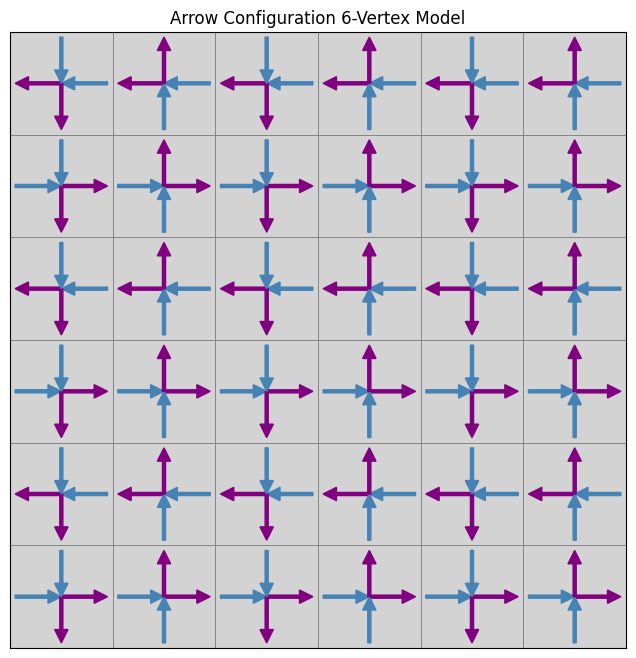

In [33]:
model = six_vertex_model(Lx = 6, Ly = 6)
model.check_valid_config()
model.fancy_plot()

In [34]:
# Simulate ice-type model with defects
def run_worm_simulation(Lx, Ly, Niter, corr_type='all', progress_callback=None, callback_interval=10):
    """ Run worm algorithm on 6-vertex model.
    Return (corr_type == 'all'):       correlations list of shape: (Niter, 4)
    Return (corr_type == 'rot_invar'): correlations list of shape: (Niter, 2)
    """
    icetype = six_vertex_model(Lx, Ly)
    corrs = []
    
    icetype.thermalize(Niter//10)
    for iter_count in range(Niter):
        icetype.propagate_defect()
        corrs.append(icetype.measure_correlations(corr_type))
        
        # Call progress callback
        if progress_callback and (iter_count + 1) % callback_interval == 0:
            progress_callback(iter_count + 1, Niter)
    
    return corrs

In [ ]:
# Testing area
Ls = [10, 20, 30, 40, 50]
params = {
    10: {'Ni': 1000, 'Nbins': 20},
    20: {'Ni': 800, 'Nbins': 15}, 
    30: {'Ni': 600, 'Nbins': 10},
    40: {'Ni': 400, 'Nbins': 8},
    50: {'Ni': 300,  'Nbins': 6}
}

# Initialize storage
corrs = []
corrs_avg_processed = []

# Run simulations for each lattice size
for i, L in enumerate(Ls):
    Ni, Nbins = params[L]['Ni'], params[L]['Nbins']
    Niter = Ni * Nbins
    start_time = time.time()

    # Progress callback
    def progress_callback(current_iter, total_iter):
        runtime = (time.time() - start_time) / 60
        progress_pct = (current_iter / total_iter) * 100
        overall_pct = (i + progress_pct/100) / len(Ls) * 100
        print(f"Progress: L = {L} | Overall: {overall_pct:.1f}% | Iter: {current_iter}/{total_iter} ({progress_pct:.1f}%) | Runtime: {runtime:.1f}min", end="\r", flush=True)
    
    # Run worm simulation
    corrs.append(run_worm_simulation(L, L, Niter, corr_type='all', progress_callback=progress_callback, callback_interval=10))
    print(f"Progress: L = {L} | {(i+1) / len(Ls) * 100:.2f}% | runtime: {(time.time()-start_time)/60:.0f}min | COMPLETED")
    
    # Binning analysis
    bin_averages = []
    for j in range(Nbins):
        bin_corrs = corrs[-1][j*Ni:(j+1)*Ni]
        bin_avg = [np.mean([bin_corrs[k][corr_type] for k in range(Ni)], axis=0) for corr_type in range(4)]
        bin_averages.append(bin_avg)
    
    corrs_avg_processed.append(bin_averages)

# Extract correlations and errors for each type
corr_types = ['hor_hor', 'ver_ver', 'ver_hor', 'hor_ver']
correlations = {corr_type: [] for corr_type in corr_types}
errors = {f'err_{corr_type}': [] for corr_type in corr_types}

for i, L in enumerate(Ls):
    Nbins = params[L]['Nbins']
    
    for j, corr_type in enumerate(corr_types):
        # Extract data for this correlation type across all bins
        bin_data = [corrs_avg_processed[i][k][j] for k in range(Nbins)]
        
        # Calculate mean and standard error
        correlations[corr_type].append(np.mean(bin_data, axis=0))
        errors[f'err_{corr_type}'].append(np.std(bin_data, axis=0) / np.sqrt(Nbins))

# Calculate combined correlations
corrs_avg_along = [(correlations['hor_hor'][i] + correlations['ver_ver'][i]) / 2 for i in range(len(Ls))]
corrs_avg_prep = [(correlations['ver_hor'][i] + correlations['hor_ver'][i]) / 2 for i in range(len(Ls))]

# Calculate combined errors
err_avg_along = []
err_avg_prep = []

for i, L in enumerate(Ls):
    Nbins = params[L]['Nbins']
    
    along_data = [(corrs_avg_processed[i][j][0] + corrs_avg_processed[i][j][1]) / 2 for j in range(Nbins)]
    prep_data = [(corrs_avg_processed[i][j][2] + corrs_avg_processed[i][j][3]) / 2 for j in range(Nbins)]
    
    err_avg_along.append(np.std(along_data, axis=0) / np.sqrt(Nbins))
    err_avg_prep.append(np.std(prep_data, axis=0) / np.sqrt(Nbins))

# Save data
os.makedirs('data', exist_ok=True)

for i, L in enumerate(Ls):
    Ni, Nbins = params[L]['Ni'], params[L]['Nbins']
    Niter = Ni * Nbins
    
    # Save all correlation types separately
    np.savez(f'data/L{L}_N{Niter}_{Ni}x{Nbins}bins_all.npz',
             **{f'corr_{corr_type}': correlations[corr_type][i] for corr_type in corr_types},
             **{f'err_{corr_type}': errors[f'err_{corr_type}'][i] for corr_type in corr_types})
    
    # Save combined correlations
    np.savez(f'data/L{L}_N{Niter}_{Ni}x{Nbins}bins_final.npz',
             corr_along=corrs_avg_along[i], corr_prep=corrs_avg_prep[i],
             err_along=err_avg_along[i], err_prep=err_avg_prep[i])

Progress: L = 10 | 20.00% | runtime: 3min | COMPLETED (100.0%) | Runtime: 2.9min
Progress: L = 20 | 40.00% | runtime: 13min | COMPLETED(100.0%) | Runtime: 13.2min
Progress: L = 30 | 60.00% | runtime: 21min | COMPLETED00.0%) | Runtime: 21.3min
Progress: L = 40 | 80.00% | runtime: 30min | COMPLETED00.0%) | Runtime: 29.7min
Progress: L = 50 | 100.00% | runtime: 33min | COMPLETED00.0%) | Runtime: 33.5min


In [ ]:
Ls = [10] # [20, 30, 40, 50]
Ni = 1000
Nbins = 20
Niter = Ni * Nbins
corr_type = 'all' # all, final

Rs = [np.arange(1, L) for L in Ls]
end = None

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 10), dpi=144)
fig.suptitle('Arrow Correlations in the 6-Vertex Model', fontsize=16)

for i, L in enumerate(Ls):
    data = np.load('data/L%s_N%s_%sx%sbins_%s.npz' % (L, Niter, Ni, Nbins, corr_type))
    
    # Correlations along arrow directions
    corr_hor_hor = data['corr_hor_hor']
    corr_ver_ver = data['corr_ver_ver']
    err_hor_hor = data['err_hor_hor']
    err_ver_ver = data['err_ver_ver']
    
    axes[0,0].errorbar(Rs[i], corr_hor_hor, err_hor_hor, fmt='.-', label='Horizontal')
    axes[0,0].errorbar(Rs[i], corr_ver_ver, err_ver_ver, fmt='.-', label='Vertical')
    axes[0,0].set_title('Correlations along arrow directions')
    axes[0,0].set_xlabel('r')
    axes[0,0].set_ylabel('$<s_0 s_r>$')
    axes[0,0].legend()
    
    # Correlations perpendicular to arrow direction
    corr_ver_hor = data['corr_ver_hor']
    corr_hor_ver = data['corr_hor_ver']
    err_ver_hor = data['err_ver_hor']
    err_hor_ver = data['err_hor_ver']
    
    axes[0,1].errorbar(Rs[i][:end], corr_ver_hor[:end], err_ver_hor[:end], 
                       fmt='.-', label='Ver-Hor (perpendicular)')
    axes[0,1].errorbar(Rs[i][:end], corr_hor_ver[:end], err_hor_ver[:end], 
                       fmt='.-', label='Hor-Ver (perpendicular)')
    axes[0,1].set_title('Correlations perpendicular to arrow direction')
    axes[0,1].set_xlabel('r')
    axes[0,1].set_ylabel('$<s_0 s_r>$')
    axes[0,1].legend()

plt.tight_layout()
plt.savefig('plots/L%s_N%s_%sx%sbins_correlations.png' % (Ls[0], Niter, Ni, Nbins), dpi=144)
plt.show()

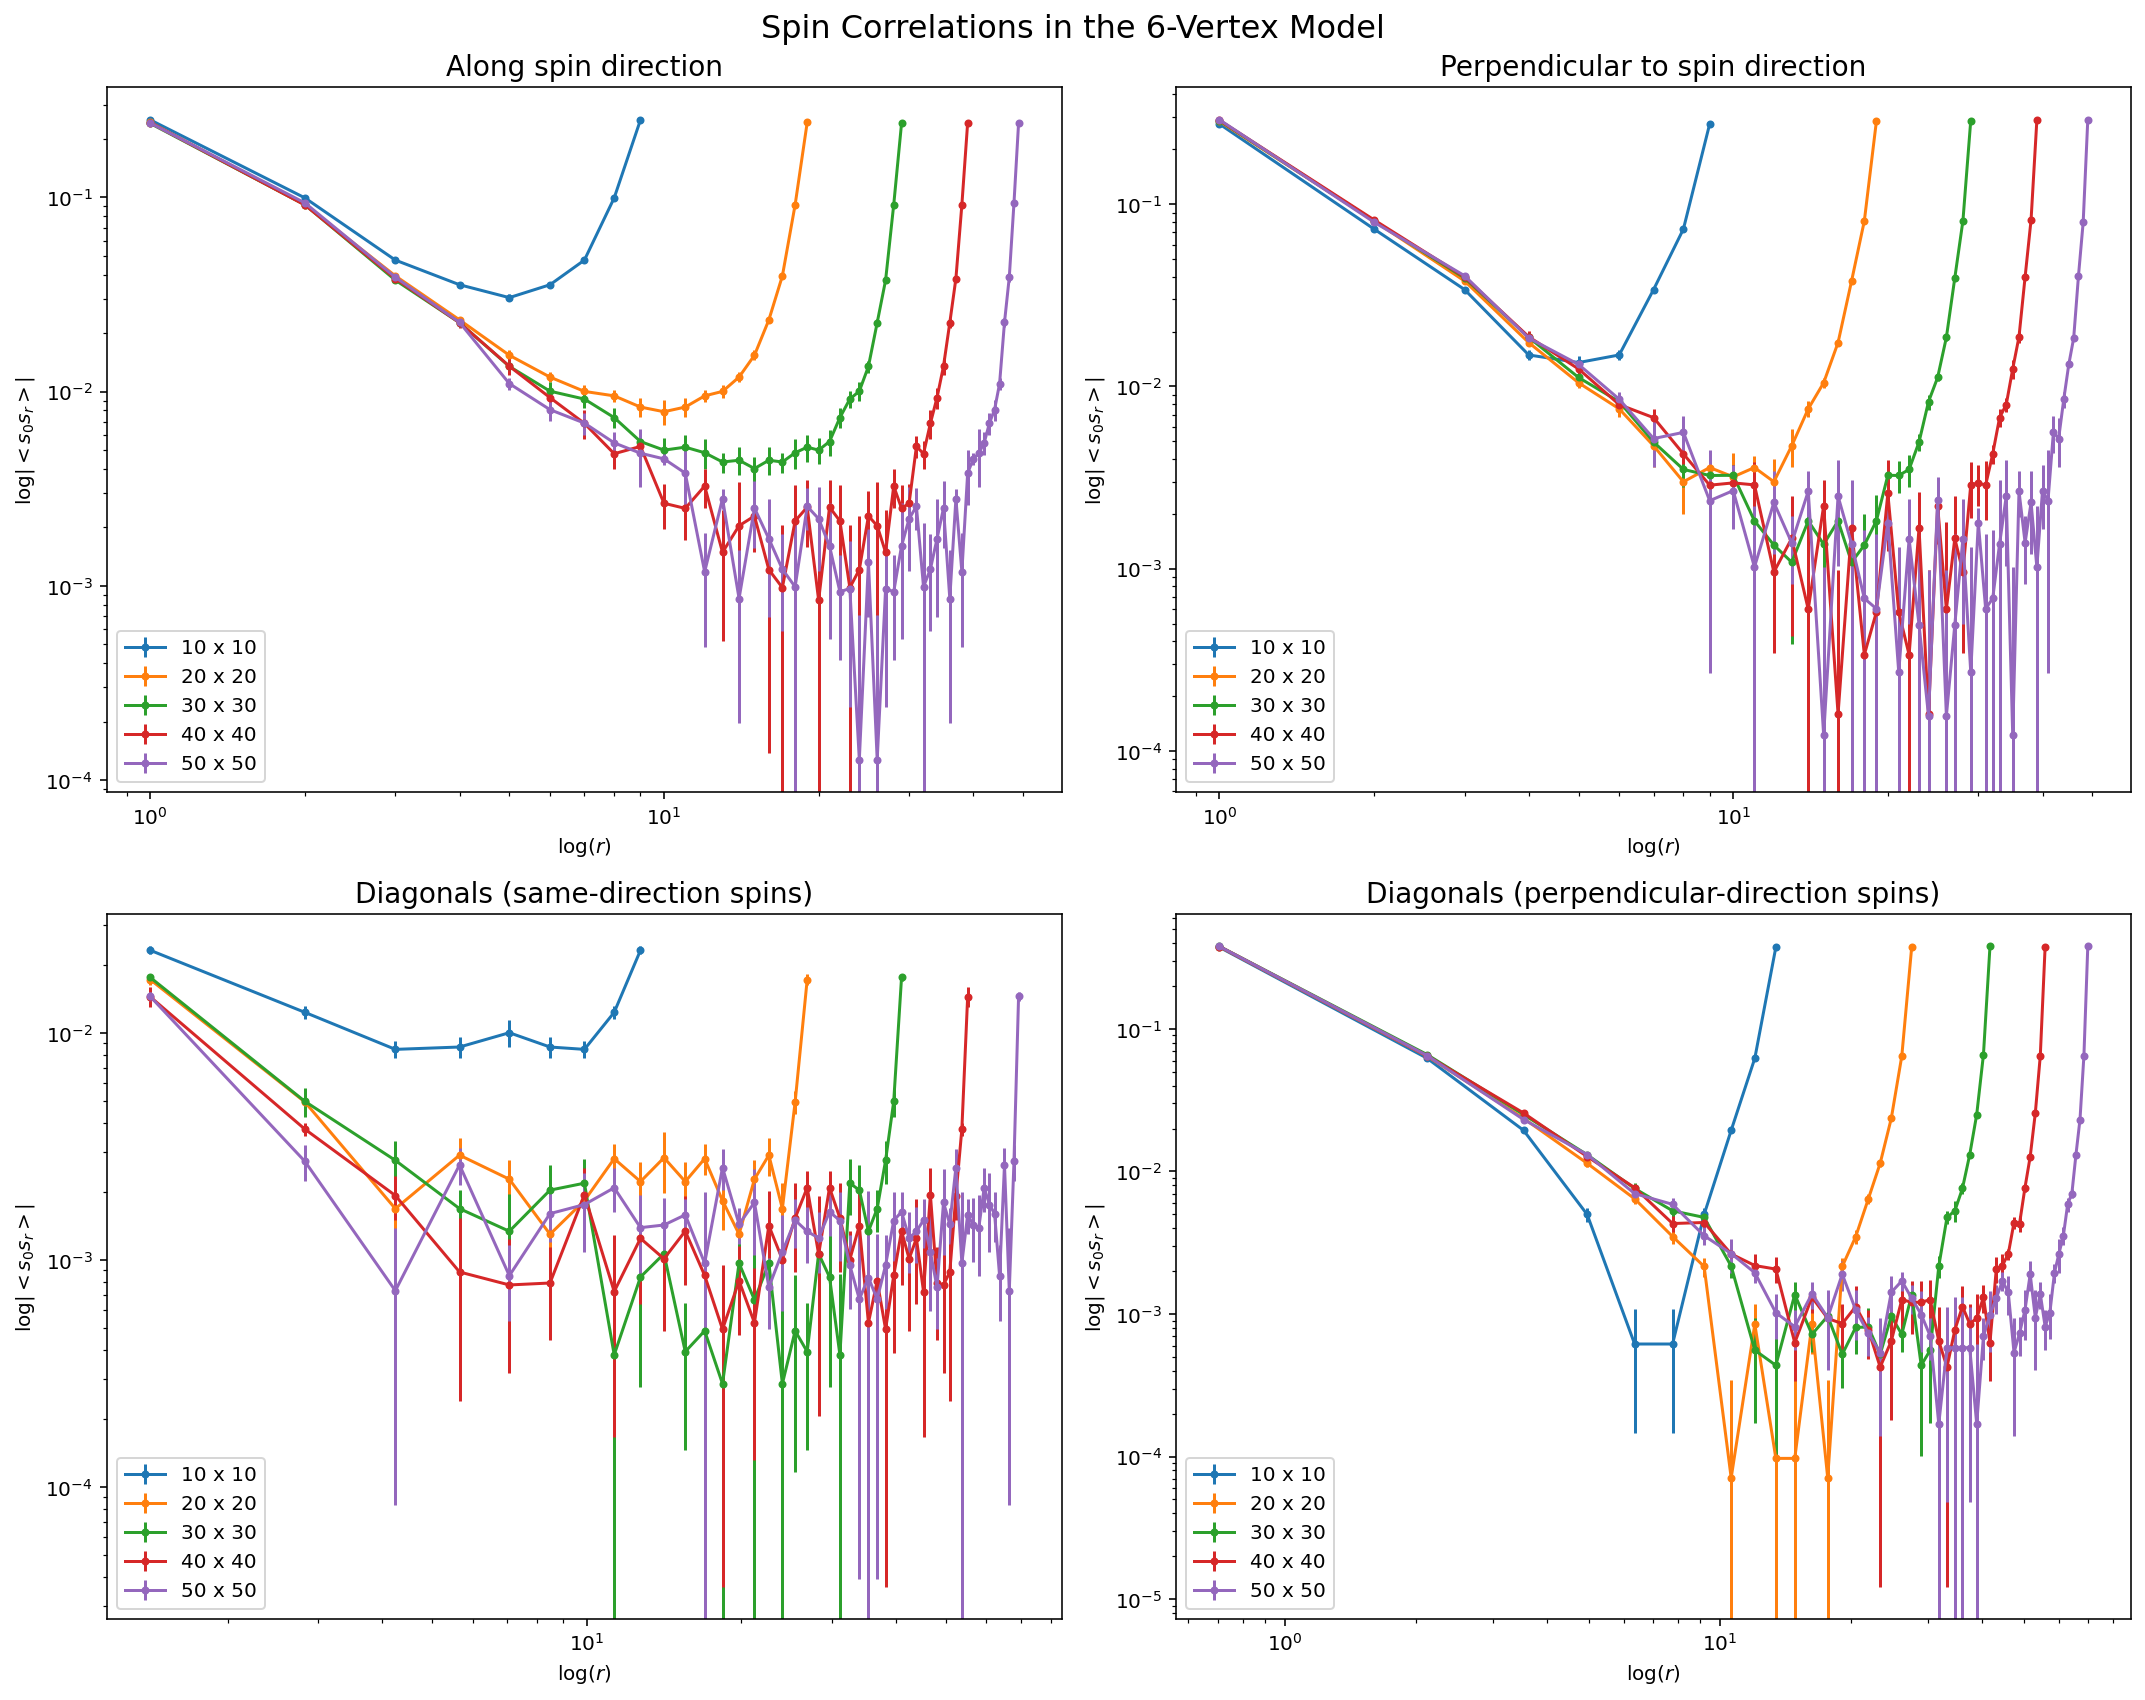

In [ ]:
# Plot correlations for multiple lattice sizes using 'final' data in subplot format
Ls = [10, 20, 30, 40, 50] 
params = {
    10: {'Ni': 1000, 'Nbins': 20},
    20: {'Ni': 800, 'Nbins': 15}, 
    30: {'Ni': 600, 'Nbins': 10},
    40: {'Ni': 400, 'Nbins': 8},
    50: {'Ni': 300,  'Nbins': 6}
}
corr_type = 'final'  # all, final

Rs = [np.arange(1, L) for L in Ls]
Rsd = [np.sqrt(1/2) * np.arange(1, 2*L) for L in Ls]  # diagonal
end = None

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=144)
fig.suptitle('Arrow Correlations in the 6-Vertex Model', fontsize=16)

# Plot 1: Along arrow direction
for i, L in enumerate(Ls):
    Ni = params[L]['Ni']
    Nbins = params[L]['Nbins']
    Niter = Ni * Nbins
    
    data = np.load('data/L%s_N%s_%sx%sbins_%s.npz' % (L, Niter, Ni, Nbins, corr_type))
    corr_along = data['corr_along']
    err_along = data['err_along']
    
    axes[0,0].errorbar(Rs[i][:end], np.abs(corr_along[:end]), err_along[:end],
                       fmt='.-', label='%s x %s' % (L, L))

axes[0,0].set_title('Along arrow direction', fontsize=14)
axes[0,0].set_xlabel('$\\log(r)$', fontsize=10)
axes[0,0].set_ylabel('$\\log|<s_0 s_r>|$', fontsize=10)
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].legend()

# Plot 2: Perpendicular to arrow direction
for i, L in enumerate(Ls):
    Ni = params[L]['Ni']
    Nbins = params[L]['Nbins']
    Niter = Ni * Nbins
    
    data = np.load('data/L%s_N%s_%sx%sbins_%s.npz' % (L, Niter, Ni, Nbins, corr_type))
    corr_prep = data['corr_prep']
    err_prep = data['err_prep']
    
    axes[0,1].errorbar(Rs[i][:end], np.abs(corr_prep[:end]), err_prep[:end],
                       fmt='.-', label='%s x %s' % (L, L))

axes[0,1].set_title('Perpendicular to arrow direction', fontsize=14)
axes[0,1].set_xlabel('$\\log(r)$', fontsize=10)
axes[0,1].set_ylabel('$\\log |<s_0 s_r>|$', fontsize=10)
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].legend()

plt.tight_layout()
plt.savefig('plots/all_final_correlations_subplots.png')
plt.show()

Along - L10 : 	a : 1.620 +- 0.187,	b : -1.191 +- 0.159
Along - L20 : 	a : 1.991 +- 0.043,	b : -1.011 +- 0.036
Along - L30 : 	a : 2.124 +- 0.055,	b : -0.920 +- 0.046
Along - L40 : 	a : 2.099 +- 0.030,	b : -0.937 +- 0.024
Perpendicular - L10 : 	a : 2.013 +- 0.210,	b : -1.216 +- 0.173
Perpendicular - L20 : 	a : 2.068 +- 0.152,	b : -1.065 +- 0.140
Perpendicular - L30 : 	a : 1.981 +- 0.131,	b : -1.116 +- 0.125
Perpendicular - L40 : 	a : 1.890 +- 0.094,	b : -1.190 +- 0.069
Diagonal (same-dir) - L10 : 	a : 0.403 +- 0.240,	b : -4.028 +- 0.335
Diagonal (same-dir) - L20 : 	a : 0.866 +- 0.394,	b : -4.451 +- 0.553
Diagonal (same-dir) - L30 : 	a : 1.554 +- 0.054,	b : -3.677 +- 0.072
Diagonal (same-dir) - L40 : 	a : 1.755 +- 0.184,	b : -3.754 +- 0.200
Diagonal (perp-dir) - L10 : 	a : 2.353 +- 0.180,	b : -1.000 +- 0.169
Diagonal (perp-dir) - L20 : 	a : 2.033 +- 0.042,	b : -1.209 +- 0.039
Diagonal (perp-dir) - L30 : 	a : 1.905 +- 0.007,	b : -1.284 +- 0.007
Diagonal (perp-dir) - L40 : 	a : 1.878 +- 0.0

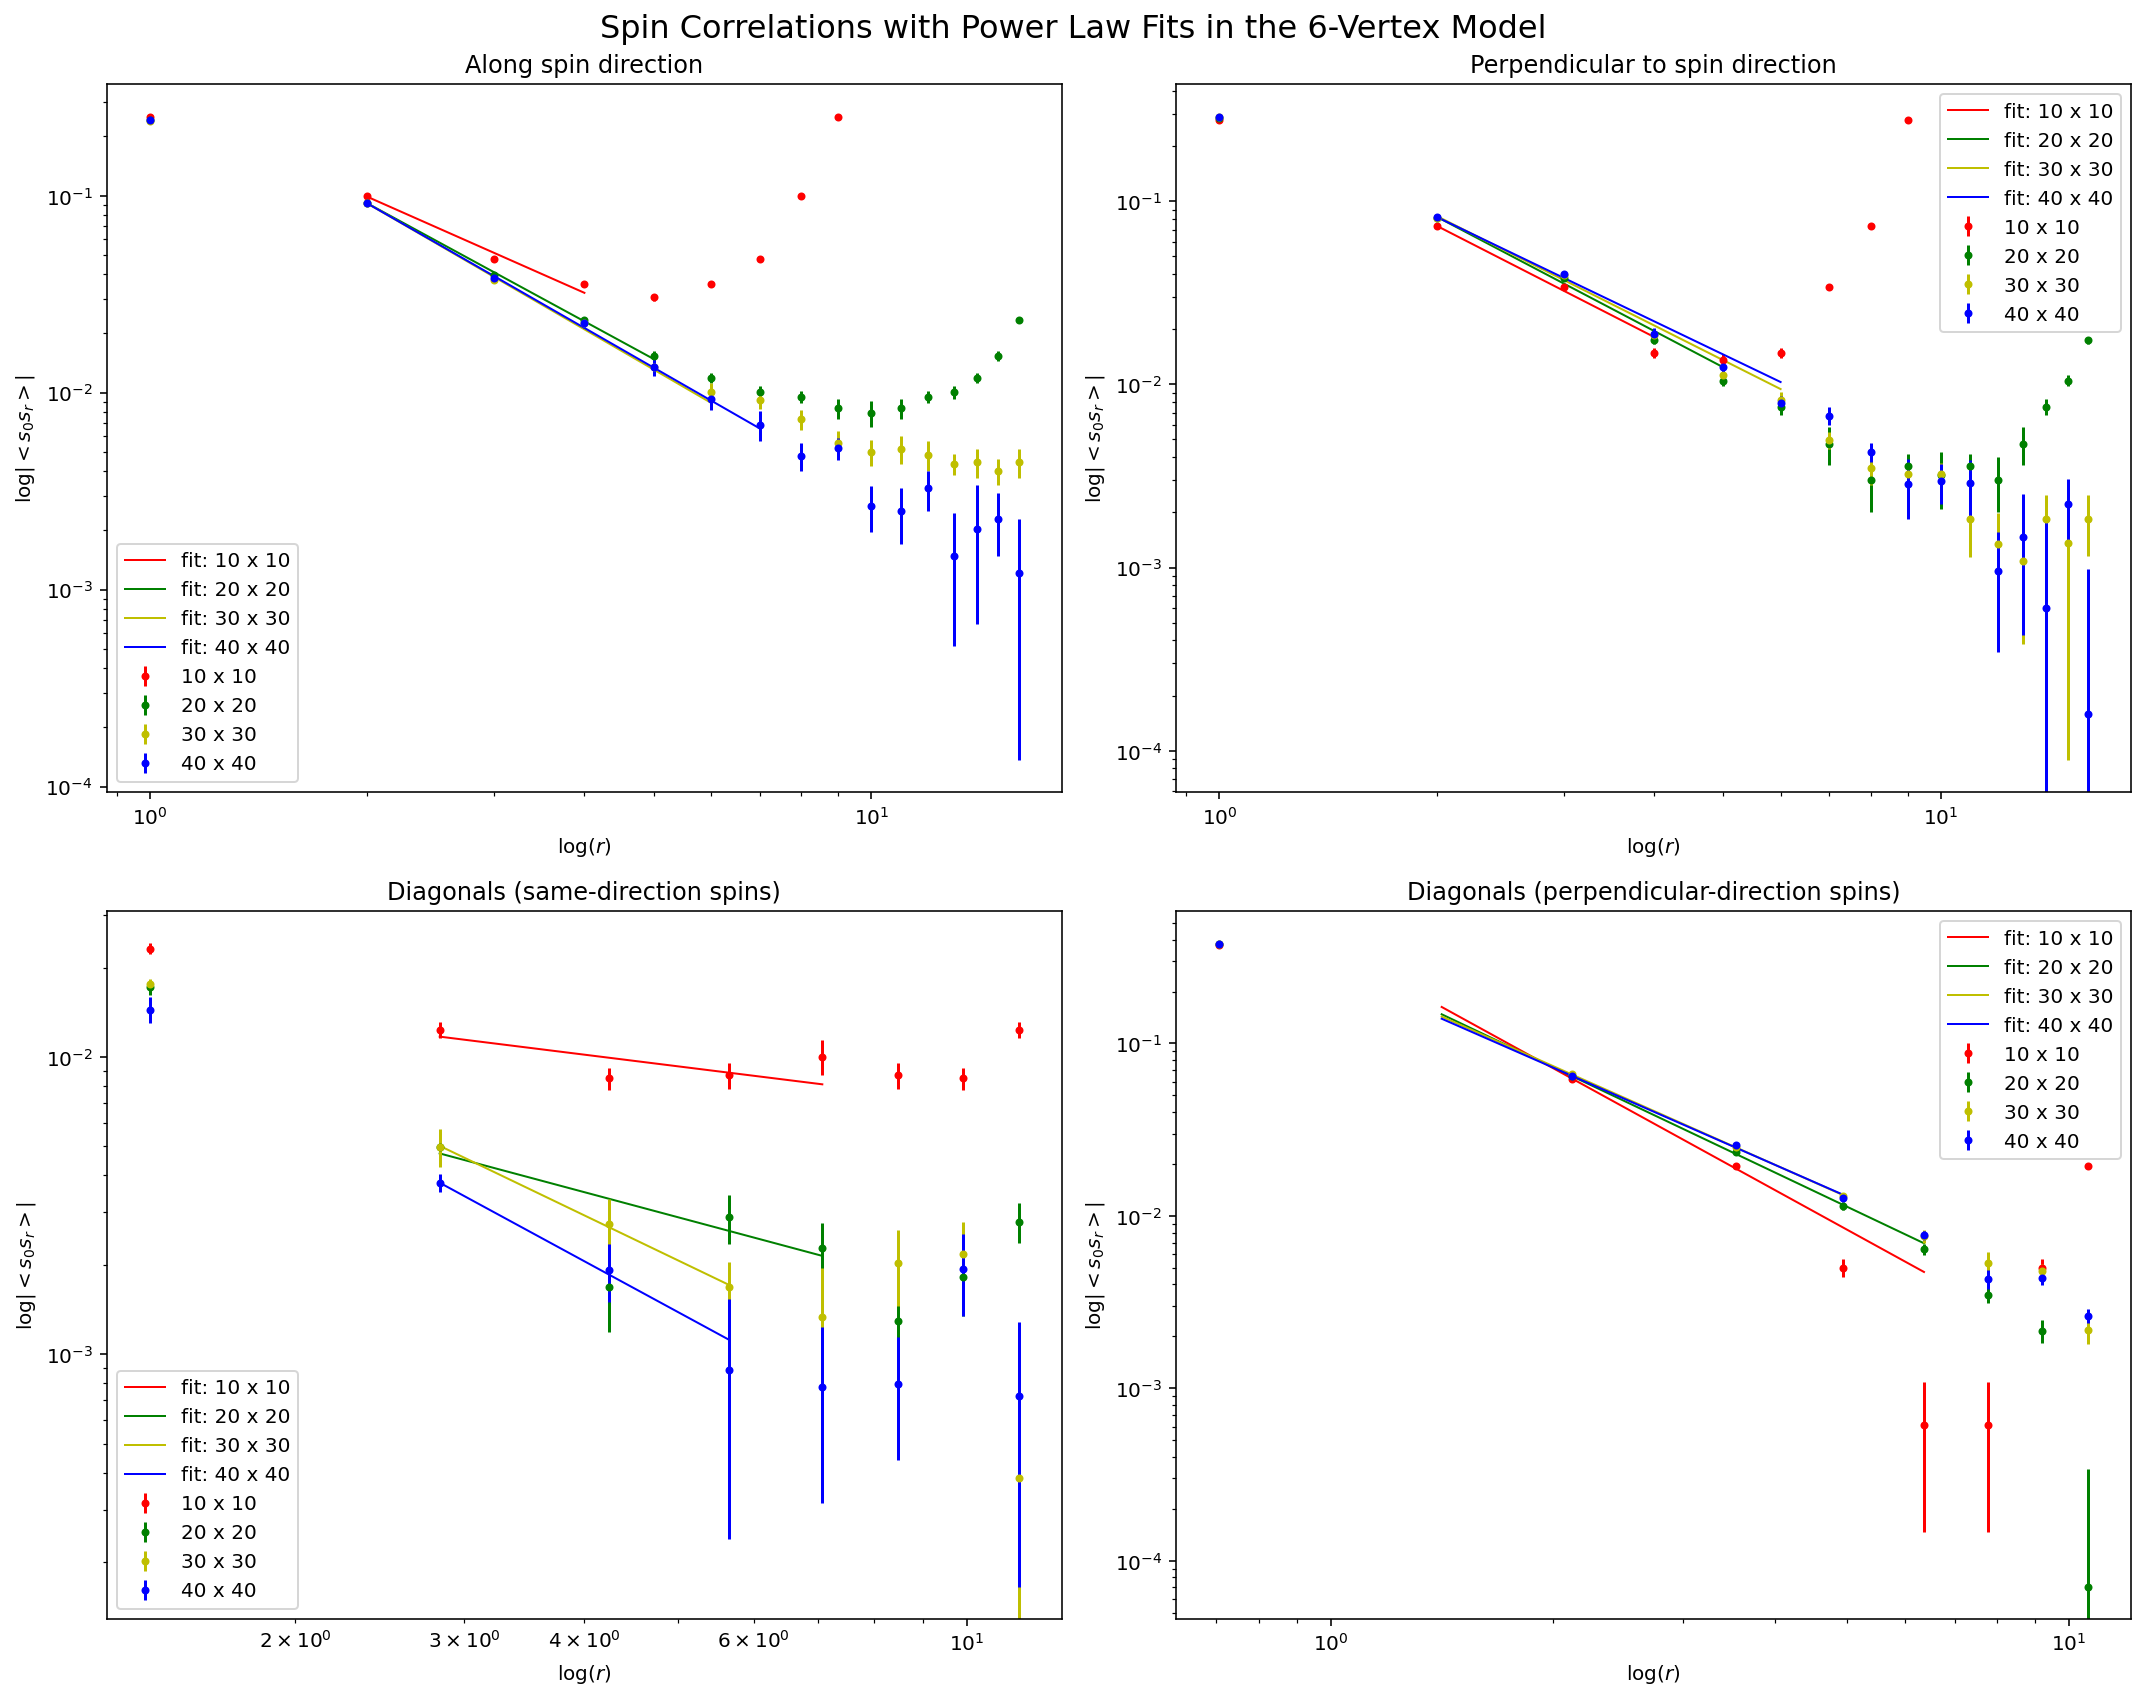

In [ ]:
# Plot correlations with fits in subplot structure
fit = lambda x, a, b: -a * x + b

Ls = [10, 20, 30, 40, 50] 
params = {
    10: {'Ni': 1000, 'Nbins': 20},
    20: {'Ni': 800, 'Nbins': 15}, 
    30: {'Ni': 600, 'Nbins': 10},
    40: {'Ni': 400, 'Nbins': 8},
    50: {'Ni': 300,  'Nbins': 6}
}
corr_type = 'final'

Rs = [np.arange(1, L) for L in Ls]
Rsd = [np.sqrt(1/2) * np.arange(1, 2*L) for L in Ls]  # diagonal
end = Ls[-1] // 3  # plot endpoint
colors = 'rgyb'  # colors for each L

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=144)
fig.suptitle('Arrow Correlations with Power Law Fits in the 6-Vertex Model', fontsize=16)

# Plot 1: Along arrow direction
endfits = (4, 5, 6, 7)  # fit endpoint
for i, L, endfit, color in zip(range(len(Ls)), Ls, endfits, colors):
    Ni = params[L]['Ni']
    Nbins = params[L]['Nbins']
    Niter = Ni * Nbins
    
    data = np.load('data/L%s_N%s_%sx%sbins_%s.npz' % (L, Niter, Ni, Nbins, corr_type))
    corr_along = data['corr_along']
    err_along = data['err_along']
    
    axes[0,0].errorbar(Rs[i][:end], np.abs(corr_along[:end]), err_along[:end],
                       fmt=color+'.', label='%s x %s' % (L, L))
    
    # least-squares fit
    pars, pars_cov = optimize.curve_fit(fit, np.log(Rs[i][1:endfit]),
                                        np.log(np.abs(corr_along[1:endfit])), p0=(1/3, 0),
                                        sigma = err_along[1:endfit] / np.abs(corr_along[1:endfit]))
    print('Along - L%i : \ta : %.3f +- %.3f,\tb : %.3f +- %.3f' %
          (L, pars[0], np.sqrt(np.diag(pars_cov))[0], pars[1], np.sqrt(np.diag(pars_cov))[1]))

    r = np.log(np.linspace(2, Rs[i][endfit-1], 100))
    axes[0,0].plot(np.exp(r), np.exp(fit(r, *pars)), color+'-', linewidth=1., label='fit: %s x %s' % (L, L))

axes[0,0].set_title('Along arrow direction')
axes[0,0].set_xlabel('$\\log(r)$')
axes[0,0].set_ylabel('$\\log |<s_0 s_r>|$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].legend()

# Plot 2: Perpendicular to arrow direction
endfits = (4, 5, 6, 6)  # fit endpoint
for i, L, endfit, color in zip(range(len(Ls)), Ls, endfits, colors):
    Ni = params[L]['Ni']
    Nbins = params[L]['Nbins']
    Niter = Ni * Nbins
    
    data = np.load('data/L%s_N%s_%sx%sbins_%s.npz' % (L, Niter, Ni, Nbins, corr_type))
    corr_prep = data['corr_prep']
    err_prep = data['err_prep']
    
    axes[0,1].errorbar(Rs[i][:end], np.abs(corr_prep[:end]), err_prep[:end],
                       fmt=color+'.', label='%s x %s' % (L, L))
    
    # least-squares fit
    pars, pars_cov = optimize.curve_fit(fit, np.log(Rs[i][1:endfit]),
                                        np.log(np.abs(corr_prep[1:endfit])), p0=(1/3, 0),
                                        sigma = err_prep[1:endfit] / np.abs(corr_prep[1:endfit]))
    print('Perpendicular - L%i : \ta : %.3f +- %.3f,\tb : %.3f +- %.3f' %
          (L, pars[0], np.sqrt(np.diag(pars_cov))[0], pars[1], np.sqrt(np.diag(pars_cov))[1]))

    r = np.log(np.linspace(2, Rs[i][endfit-1], 100))
    axes[0,1].plot(np.exp(r), np.exp(fit(r, *pars)), color+'-', linewidth=1., label='fit: %s x %s' % (L, L))

axes[0,1].set_title('Perpendicular to arrow direction')
axes[0,1].set_xlabel('$\\log(r)$')
axes[0,1].set_ylabel('$\\log |<s_0 s_r>|$')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].legend()

plt.tight_layout()
plt.savefig('plots/all_final_correlations_fits_subplots.png', dpi=144)
plt.show()

should be around a = 0.5, comment on ergodicity and detailed balance